## Predict which Data Scientists are likely to change jobs

Dataset from [HR Analytics: Job Change of Data Scientists](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # visualize missing values
from sklearn.impute import KNNImputer # fill missing values
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # oversampling

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("data/aug_train.csv")

In [3]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
df["target"].value_counts(dropna=False)

0.0    14381
1.0     4777
Name: target, dtype: int64

## 1. Feature Engineering

### 1.1 Use KNNImputer for imputation of missing values using k-Nearest Neighbors

In [6]:
temp_df = df.copy()
temp_df = temp_df.drop(columns=["enrollee_id", "target"]) # Drop id and target because these cols have no corr to the rest

<AxesSubplot:>

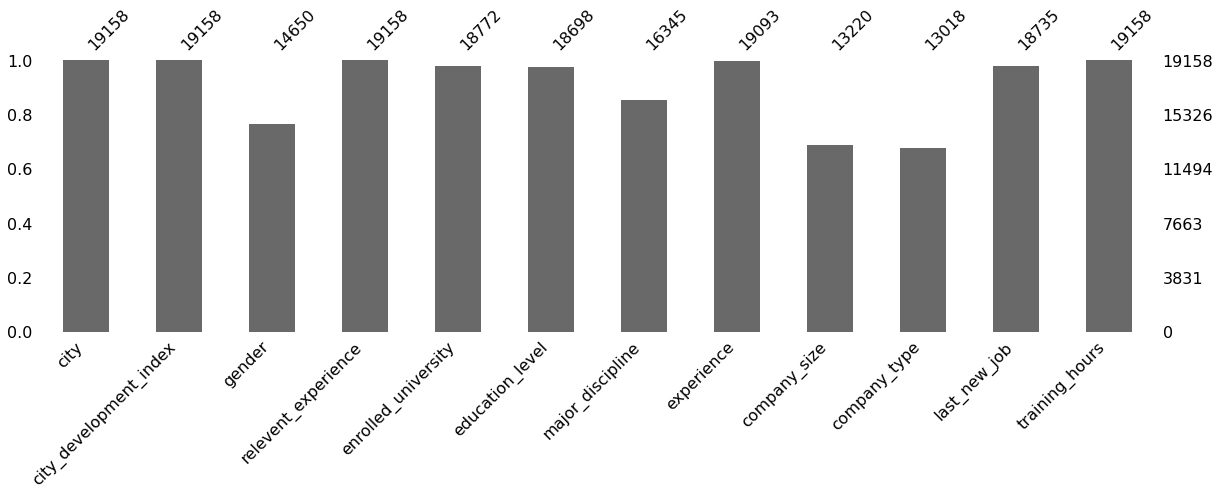

In [7]:
# Missing values
msno.bar(temp_df, figsize=(20,5))

<AxesSubplot:>

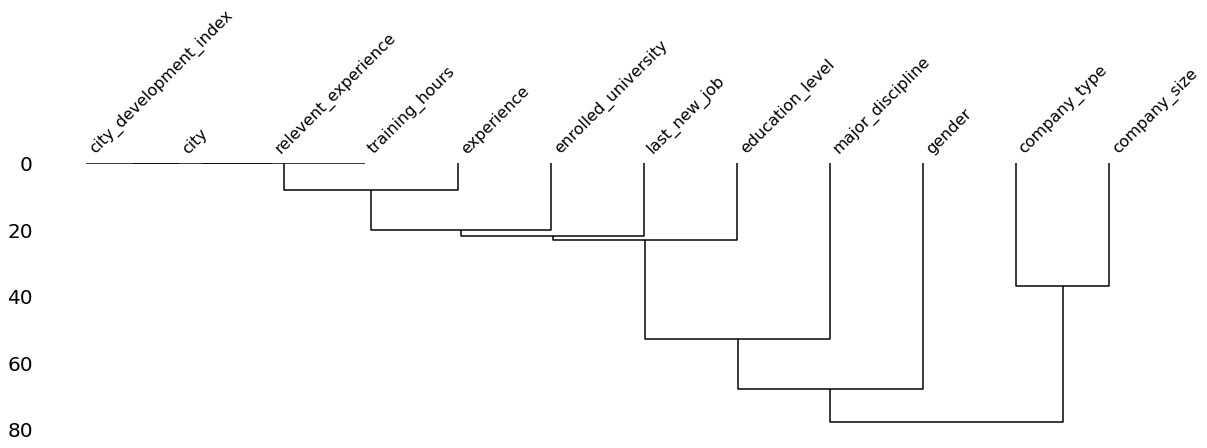

In [8]:
# Relationship between missing values
msno.dendrogram(temp_df, figsize=(20,5))

In [9]:
temp_df = temp_df.astype("category")
all_cols = temp_df.columns
cat_dict = {} # dictionary to store cat codes for reverse conversion
all_cols = temp_df.columns

for i in all_cols:
    cat_dict[i] = dict(enumerate(temp_df[i].cat.categories))
    temp_df[i] = temp_df[i].cat.codes

temp_df = temp_df.replace(-1, np.nan) # by default, nan values are converted to -1, converting them back to nan
temp_df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,5,85,1.0,0,2.0,0.0,5.0,21.0,NaN,NaN,0.0,35
1,77,48,1.0,1,2.0,0.0,5.0,6.0,4.0,5.0,4.0,46
2,64,14,NaN,1,0.0,0.0,5.0,15.0,NaN,NaN,5.0,82
3,14,52,NaN,1,NaN,0.0,1.0,20.0,NaN,5.0,5.0,51
4,50,45,1.0,0,2.0,2.0,5.0,21.0,4.0,1.0,3.0,7


In [10]:
# Using KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")
imputer.fit(temp_df)
x = imputer.transform(temp_df)
temp_df = pd.DataFrame(x, columns=all_cols)
temp_df = temp_df.round() # rounding of filled values
temp_df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,5.0,85.0,1.0,0.0,2.0,0.0,5.0,21.0,3.0,4.0,0.0,35.0
1,77.0,48.0,1.0,1.0,2.0,0.0,5.0,6.0,4.0,5.0,4.0,46.0
2,64.0,14.0,1.0,1.0,0.0,0.0,5.0,15.0,3.0,4.0,5.0,82.0
3,14.0,52.0,1.0,1.0,1.0,0.0,1.0,20.0,3.0,5.0,5.0,51.0
4,50.0,45.0,1.0,0.0,2.0,2.0,5.0,21.0,4.0,1.0,3.0,7.0


In [11]:
# Convert cat codes back to cat values
for i in all_cols:
    temp_df[i] = temp_df[i].map(cat_dict[i])

In [12]:
df_clean = df.copy()
df_clean.loc[:, all_cols] = temp_df
df_clean.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Public Sector,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,10000+,Public Sector,never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,Part time course,Graduate,Business Degree,<1,10000+,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### 1.2 One hot encode categorical data

In [13]:
df_clean = df_clean.drop(columns=["enrollee_id", "city"]) # drop non-essential cols
cat_cols = df_clean.drop(columns=["city_development_index", "training_hours", "target"]).columns.tolist()

df_dummies = pd.get_dummies(df_clean, columns=cat_cols) # one hot encode cat values
df_dummies.head()

,city_development_index,training_hours,target,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_10,experience_11,experience_12,experience_13,experience_14,experience_15,experience_16,experience_17,experience_18,experience_19,experience_2,experience_20,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,experience_<1,experience_>20,company_size_10/49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,36,1.0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0.776,47,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0.624,83,0.0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0.789,52,1.0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.767,8,0.0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### 1.3 Normalize data

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
min_max_scaler = MinMaxScaler()
x = df_dummies[["city_development_index", "training_hours"]]
min_max_scaler = min_max_scaler.fit(x)
scaled_x = min_max_scaler.transform(x)

df_dummies[["city_development_index", "training_hours"]] = scaled_x

In [16]:
df_dummies.head()

,city_development_index,training_hours,target,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_10,experience_11,experience_12,experience_13,experience_14,experience_15,experience_16,experience_17,experience_18,experience_19,experience_2,experience_20,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,experience_<1,experience_>20,company_size_10/49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.942116,0.104478,1.0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0.654691,0.137313,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0.351297,0.244776,0.0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0.680639,0.152239,1.0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.636727,0.020896,0.0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### 1.4 Oversampling of minority class

In [17]:
# Using SMOTE for oversampling
oversample = SMOTE()

In [18]:
features = df_dummies.loc[:, df_dummies.columns != "target"]
labels = df_dummies["target"]

print("Pre oversampling (target):")
print(labels.value_counts())
print()

features, labels = oversample.fit_resample(features, labels)

print("Post oversampling (target):")
print(labels.value_counts())

Pre oversampling (target):
0.0    14381
1.0     4777
Name: target, dtype: int64

Post oversampling (target):
0.0    14381
1.0    14381
Name: target, dtype: int64


### 1.5 Train/ test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (23009, 63)
X_test: (5753, 63)
y_train: (23009,)
y_test: (5753,)


## 2. Machine Learning

### 2.1 XGBoost

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [21]:
eval_set = [(X_train, y_train)]

model = XGBClassifier(use_label_encoder=False)

history = model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=False)

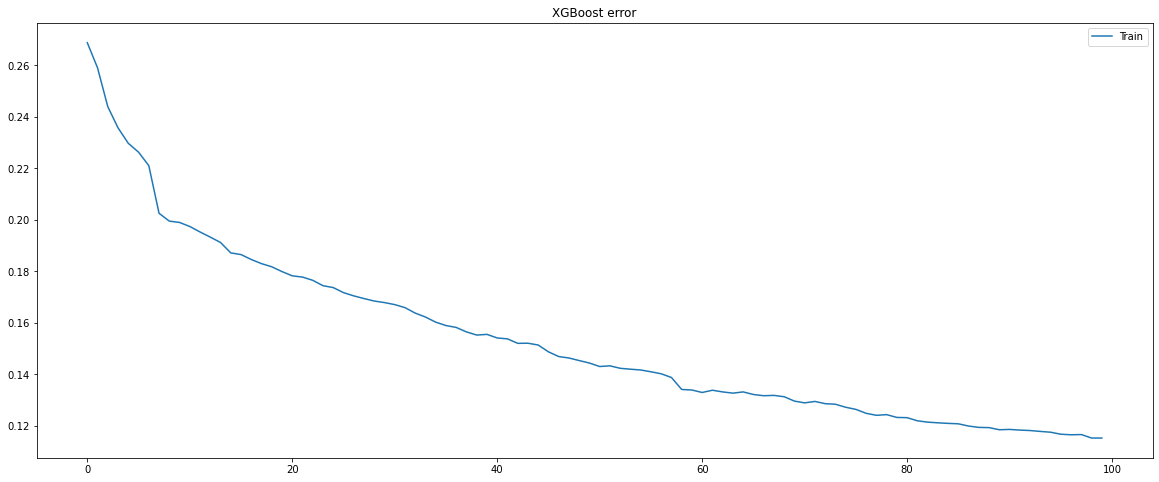

In [22]:
train_eval = history.evals_result()["validation_0"]["error"]
x_axis = range(0, len(train_eval))

plt.figure(figsize=(20,8))
plt.plot(x_axis, train_eval, label="Train")
plt.legend()
plt.title("XGBoost error")
plt.show()

In [23]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.8306970276377542


**Parameter Tuning**

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 300, 500],
        'learning_rate' : [0.1, 0.01]
    }

    xgb_model = XGBClassifier(use_label_encoder=False)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           cv = 5,
                           n_jobs = -1)

    gsearch.fit(X_train, y_train, verbose=1)

    return gsearch.best_params_

In [26]:
tuned_params = hyperParameterTuning(X_train, y_train)

[14:47:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
tuned_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.7}

In [28]:
tuned_params["user_label_encoder"] = False

tuned_model = XGBClassifier(*tuned_params)

C:\Users\HengKai\anaconda3\lib\site-packages\xgboost\core.py:416: FutureWarning: Pass `objective, use_label_encoder` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [29]:
eval_set = [(X_train, y_train)]

history = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

[16:22:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


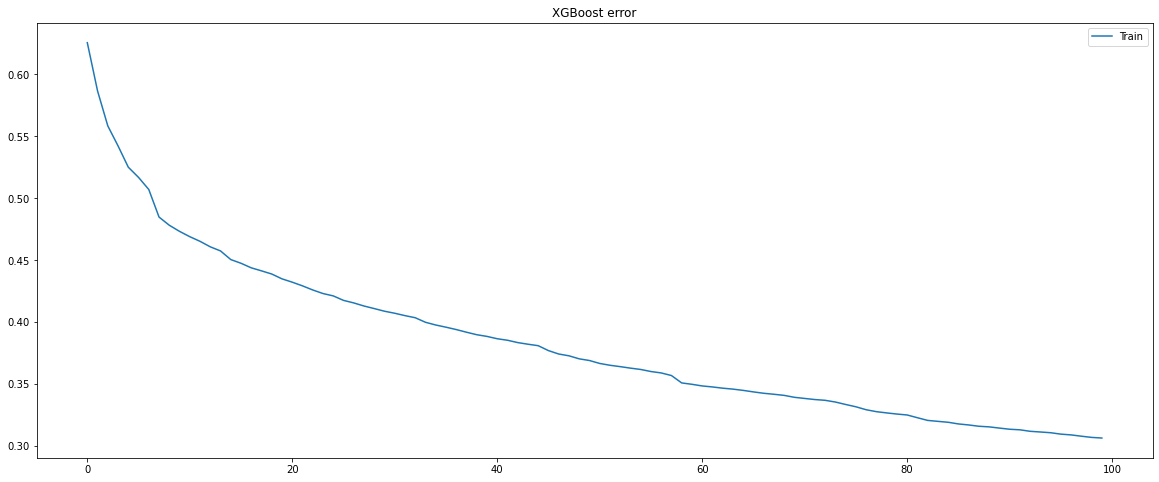

In [30]:
train_eval = history.evals_result()["validation_0"]["logloss"]
x_axis = range(0, len(train_eval))

plt.figure(figsize=(20,8))
plt.plot(x_axis, train_eval, label="Train")
plt.legend()
plt.title("XGBoost error")
plt.show()

In [31]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.8306970276377542
